In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

import warnings
warnings.filterwarnings('ignore')
#pd.reset_option('display.max_columns')

from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import RFECV, RFE, SelectFromModel, SelectKBest, chi2
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler, Normalizer, QuantileTransformer, PowerTransformer
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier, ExtraTreesRegressor, RandomForestClassifier, BaggingClassifier, ExtraTreesClassifier, RandomForestRegressor
from sklearn import feature_selection
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

from lightgbm import LGBMClassifier

import shap

### Data ensembling

In [2]:
descriptor_df = pd.read_excel('dummy.xlsx', None)
all_ligand_descriptors = []
for key in descriptor_df.keys():
    all_ligand_descriptors.append(descriptor_df[key])
descriptors_concatenated = pd.concat(all_ligand_descriptors,axis=0,ignore_index=True)

In [3]:
dummy_df = descriptors_concatenated
dummy_df.drop('Unnamed: 0', axis=1, inplace=True)

In [4]:
dummy_df.head()

,Ligand,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,39_SD-027,16.401355,12.830851,0,0,27.538947,2.351515,4.658626,27.538947,1.311378,...,9.782844,72.950827,281.116427,7.808790,1085,28,108,124,5.916667,4.638889
1,24_SD-012,23.120752,17.496509,0,0,36.792136,2.500037,4.883480,36.792136,1.268694,...,10.341904,79.079406,418.142324,8.198869,2404,45,158,185,9.562500,6.097222
2,102_wo17590_77,20.413286,16.725919,0,0,34.468616,2.492661,4.888530,34.468616,1.325716,...,10.230955,80.593694,352.164774,7.655756,1672,41,140,168,7.500000,5.805556
3,1_BMS986165_PKD_TYK2_prw_nowater_nimbus01,25.569882,20.595148,0,2,41.680715,2.508615,4.935337,41.680715,1.302522,...,10.515777,88.755240,437.192386,7.948952,2867,53,178,216,9.944444,6.888889
4,60_wo14660_81,21.489002,17.014394,0,0,35.859929,2.400952,4.801904,35.859929,1.280712,...,10.136621,63.084823,378.144038,8.220523,2107,43,142,164,9.500000,6.277778


#### Non-applying descriptors search

Search for those descriptors that could not be computed by _Modrded_ and discard them.

In [5]:
non_applying_descriptors = []
num_descriptors = len(dummy_df.columns)

for i in range(1, num_descriptors):
    if (str(dummy_df.dtypes[i]) != 'float64') and (str(dummy_df.dtypes[i]) != 'int64') and (str(dummy_df.dtypes[i]) != 'bool'):
        non_applying_descriptors.append(dummy_df.columns[i])
        

In [6]:
for descriptor in non_applying_descriptors:
    dummy_df.drop(columns=[descriptor], inplace=True)

In [7]:
dummy_df.head()

,Ligand,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,39_SD-027,16.401355,12.830851,0,0,27.538947,2.351515,4.658626,27.538947,1.311378,...,9.782844,72.950827,281.116427,7.808790,1085,28,108,124,5.916667,4.638889
1,24_SD-012,23.120752,17.496509,0,0,36.792136,2.500037,4.883480,36.792136,1.268694,...,10.341904,79.079406,418.142324,8.198869,2404,45,158,185,9.562500,6.097222
2,102_wo17590_77,20.413286,16.725919,0,0,34.468616,2.492661,4.888530,34.468616,1.325716,...,10.230955,80.593694,352.164774,7.655756,1672,41,140,168,7.500000,5.805556
3,1_BMS986165_PKD_TYK2_prw_nowater_nimbus01,25.569882,20.595148,0,2,41.680715,2.508615,4.935337,41.680715,1.302522,...,10.515777,88.755240,437.192386,7.948952,2867,53,178,216,9.944444,6.888889
4,60_wo14660_81,21.489002,17.014394,0,0,35.859929,2.400952,4.801904,35.859929,1.280712,...,10.136621,63.084823,378.144038,8.220523,2107,43,142,164,9.500000,6.277778


#### _BMS_ and _wo_ ligands dropping

We decided to discard this two groups of ligads as they come from two alternative sources. 
We keep on working with _SD_ and _LAS_.

In [8]:
for index, row in dummy_df.iterrows():
    if 'BMS' in row['Ligand']:
        dummy_df.drop(index, inplace=True)

for index, row in dummy_df.iterrows():
    if 'wo' in row['Ligand']:
        dummy_df.drop(index, inplace=True)
        
for index, row in dummy_df.iterrows():
    if '30_' in row['Ligand']:
        dummy_df.drop(index, inplace=True)

In [9]:
dummy_df.reset_index(drop=True, inplace=True)
dummy_df['Ligand']

0        39_SD-027
1        24_SD-012
2        29_SD-017
3        33_SD-021
4        17_SD-002
5        36_SD-024
6        18_SD-003
7        25_SD-013
8        23_SD-011
9     12_LAS203756
10       34_SD-022
11       28_SD-016
12       26_SD-014
13       37_SD-025
14    13_LAS203888
15       21_SD-009
16       19_SD-006
17       22_SD-010
18       35_SD-023
19       38_SD-026
20       32_SD-020
21    15_LAS203932
22       31_SD-019
23    16_LAS203965
24    14_LAS203900
25       27_SD-015
26       20_SD-008
Name: Ligand, dtype: object

In [10]:
dummy_df.sort_values(by=['Ligand'], inplace=True)
dummy_df.reset_index(drop=True, inplace=True)
dummy_df.head()

,Ligand,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,12_LAS203756,24.793826,18.444754,0,0,41.003700,2.499482,4.946810,41.003700,1.322700,...,10.454812,81.186093,423.150681,8.463014,2776,52,170,204,8.472222,6.694444
1,13_LAS203888,17.953468,15.053156,0,0,28.680180,2.481106,4.871045,28.680180,1.246964,...,10.089178,71.498752,310.154209,7.564737,1182,36,122,144,8.250000,5.027778
2,14_LAS203900,24.017769,17.838004,0,1,39.902350,2.489954,4.913111,39.902350,1.330078,...,10.391116,79.976698,406.160518,8.123210,2558,49,164,196,7.611111,6.500000
3,15_LAS203932,23.529442,19.100026,0,0,38.633155,2.438811,4.855461,38.633155,1.287772,...,10.333222,85.157707,408.165837,8.163317,2496,47,160,190,9.722222,6.583333
4,16_LAS203965,21.896449,17.252001,0,0,36.699679,2.550926,4.945786,36.699679,1.310703,...,10.312712,79.570682,379.175673,7.738279,2170,45,150,180,8.611111,6.250000


#### pIC50 values loading

In [11]:
pic50_raw = pd.read_excel('/home/alexis/Desktop/PeleAI_data/y_data.xlsx')

In [12]:
pic50_raw['Ligand']

0     12_LAS203756
1     13_LAS203888
2     14_LAS203900
3     15_LAS203932
4     16_LAS203965
5        17_SD-002
6        18_SD-003
7        19_SD-006
8        20_SD-008
9        21_SD-009
10       22_SD-010
11       23_SD-011
12       24_SD-012
13       25_SD-013
14       26_SD-014
15       27_SD-015
16       28_SD-016
17       29_SD-017
18       31_SD-019
19       32_SD-020
20       33_SD-021
21       34_SD-022
22       35_SD-023
23       36_SD-024
24       37_SD-025
25       38_SD-026
26       39_SD-027
Name: Ligand, dtype: object

### Descriptor curation

#### Correlation matrix and high correlated descriptors dropping

Computing of the correlation matrix, plotted below, of the ~1500 descriptors computed. Those descriptors that show a correlation coefficient above 0.8 will be discarded.

In [13]:
correlated_features = set()
correlation_matrix = dummy_df.drop('Ligand', axis=1).corr()

In [14]:
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i,j]) > 0.8:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)
            
print(correlated_features)

{'ATSC1m', 'GATS1p', 'GATS5are', 'MATS2v', 'ATSC0p', 'AATSC4c', 'SssssC', 'SdsN', 'AATS3m', 'AATSC3dv', 'ETA_dEpsilon_A', 'n6aHRing', 'n12FaHRing', 'GATS1Z', 'MATS6m', 'VR2_DzZ', 'ZMIC4', 'MWC06', 'ATS6s', 'AATSC7Z', 'VR3_Dzi', 'MATS8d', 'MWC07', 'Diameter', 'AATSC0c', 'MATS6d', 'SpDiam_DzZ', 'RPSA', 'PPSA5', 'IC3', 'ETA_beta_ns', 'VE3_Dzse', 'MATS7i', 'MIC5', 'AATSC6dv', 'GATS1pe', 'SpDiam_Dt', 'ATSC4m', 'AATS3d', 'ATSC3v', 'AXp-1dv', 'CIC5', 'PPSA3', 'ATSC6are', 'SpMAD_Dzi', 'n9FHRing', 'Vabc', 'ATS4Z', 'MATS1s', 'MATS4m', 'GATS3pe', 'BCUTpe-1l', 'NsssCH', 'AATS2se', 'AATSC3v', 'ATS8se', 'Xp-2d', 'SIC1', 'MPC5', 'ATSC6pe', 'AXp-5d', 'MATS1p', 'LabuteASA', 'piPC7', 'VE3_A', 'MATS1se', 'VE1_D', 'AETA_beta_ns_d', 'ETA_dBeta', 'GATS4m', 'DPSA4', 'MATS6i', 'MATS6v', 'Xp-0dv', 'AATS1m', 'piPC5', 'BCUTare-1l', 'VR2_A', 'GATS8v', 'EState_VSA9', 'ATSC0v', 'AATSC3se', 'ATS1p', 'ATS7v', 'apol', 'VE3_Dzm', 'MATS8are', 'MATS4p', 'MATS2i', 'AATSC6m', 'AATSC4d', 'AATSC4v', 'MATS7c', 'GATS4Z', 'AATS

In [15]:
print("Correlated descriptors computed: {}".format(len(correlated_features)))
print("Number of descriptors before discard: {}".format(len(dummy_df.columns)))
dummy_df = dummy_df.drop(correlated_features, axis=1)
print("Number of descriptors after discard: {}".format(len(dummy_df.columns)))

Correlated descriptors computed: 1102
Number of descriptors before discard: 1503
Number of descriptors after discard: 401


#### Correlation matrix

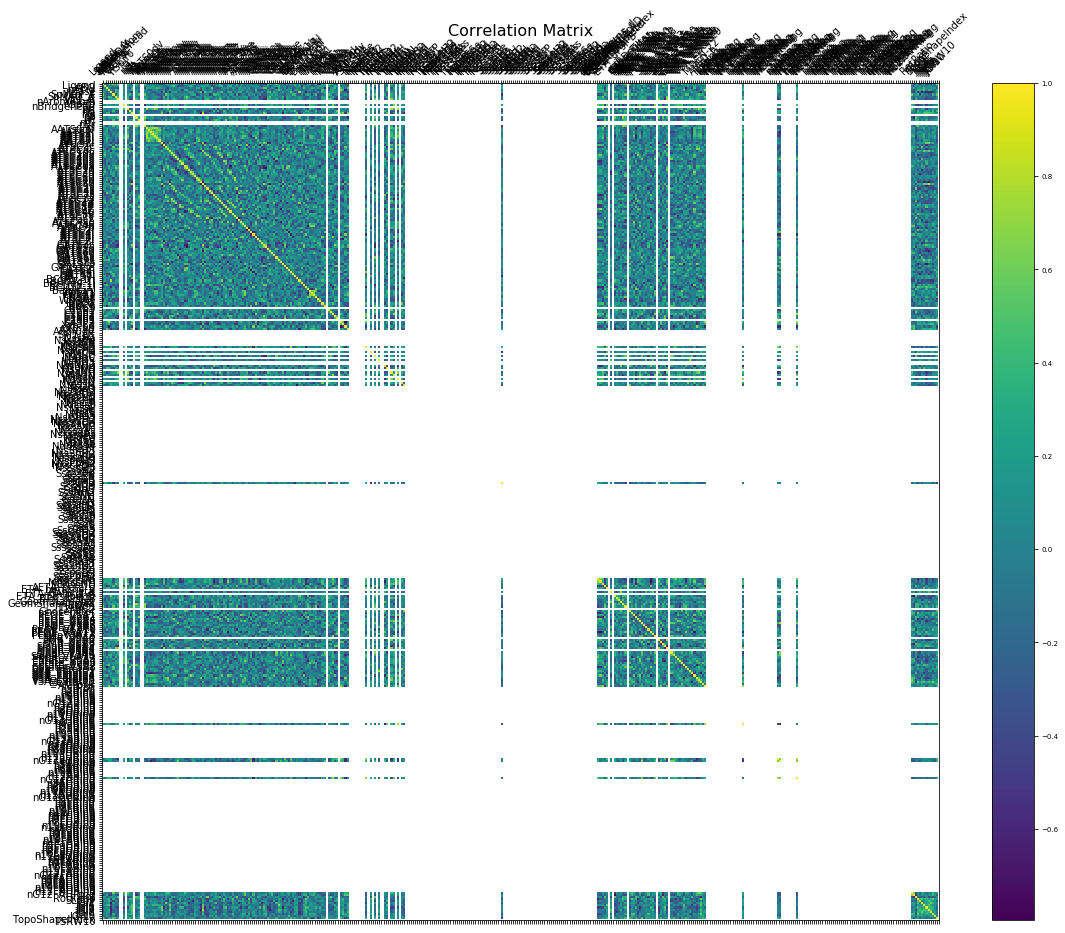

In [16]:
f = plt.figure(figsize=(19, 15))
plt.matshow(dummy_df.corr(), fignum=f.number)
plt.xticks(range(dummy_df.shape[1]), dummy_df.columns, fontsize=10, rotation=45)
plt.yticks(range(dummy_df.shape[1]), dummy_df.columns, fontsize=10)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=7)
plt.title('Correlation Matrix', fontsize=16);

### Data splitting

In [17]:
dummy_df = dummy_df.merge(pic50_raw, how='left')

In [18]:
dummy_df.head()

,Ligand,ABC,nAcid,nBase,SpMax_A,SpMAD_A,VE1_A,VR1_A,nAromAtom,nSpiro,...,JGI4,JGI5,JGI6,JGI7,JGI8,JGI9,JGI10,TopoShapeIndex,TSRW10,IC50
0,12_LAS203756,24.793826,0,0,2.499482,1.322700,4.440538,597.574331,18,0,...,0.026757,0.028958,0.017766,0.015289,0.008381,0.006972,0.006926,0.875,81.186093,-4.824
1,13_LAS203888,17.953468,0,0,2.481106,1.246964,3.925606,230.400001,15,0,...,0.040794,0.033704,0.018925,0.013818,0.014253,0.012246,0.004115,1.000,71.498752,-10.292
2,14_LAS203900,24.017769,0,1,2.489954,1.330078,4.496545,499.352788,21,0,...,0.028804,0.016311,0.018386,0.012110,0.005810,0.006563,0.004835,0.875,79.976698,-7.284
3,15_LAS203932,23.529442,0,0,2.438811,1.287772,4.888546,227.217438,17,0,...,0.034610,0.025721,0.017908,0.013517,0.010860,0.008173,0.008159,1.000,85.157707,-11.456
4,16_LAS203965,21.896449,0,0,2.550926,1.310703,4.089075,1640.002566,18,0,...,0.040631,0.025306,0.017225,0.012408,0.009386,0.009661,0.006200,0.875,79.570682,-7.259


In [96]:
train, test = train_test_split(dummy_df, test_size=0.24)

In [97]:
test

,Ligand,ABC,nAcid,nBase,SpMax_A,SpMAD_A,VE1_A,VR1_A,nAromAtom,nSpiro,...,JGI4,JGI5,JGI6,JGI7,JGI8,JGI9,JGI10,TopoShapeIndex,TSRW10,IC50
10,22_SD-010,24.288920,0,1,2.367520,1.301283,4.747259,419.620993,17,0,...,0.023889,0.025965,0.015395,0.010213,0.007749,0.007639,0.006485,0.900000,80.035639,-8.721
22,35_SD-023,22.931725,0,0,2.433999,1.275335,4.873163,204.691400,17,0,...,0.029697,0.029065,0.015626,0.016370,0.008494,0.010563,0.006171,1.000000,84.032246,-6.886
13,25_SD-013,19.815569,0,0,2.478858,1.316398,4.233297,226.646650,12,0,...,0.031713,0.023701,0.017913,0.011986,0.010239,0.009219,0.004347,0.833333,79.550518,-6.456
0,12_LAS203756,24.793826,0,0,2.499482,1.322700,4.440538,597.574331,18,0,...,0.026757,0.028958,0.017766,0.015289,0.008381,0.006972,0.006926,0.875000,81.186093,-4.824
24,37_SD-025,22.753386,1,0,2.475054,1.300798,4.367584,549.602686,15,0,...,0.038463,0.026222,0.019152,0.014123,0.012124,0.009138,0.007070,0.875000,78.590066,-6.854
1,13_LAS203888,17.953468,0,0,2.481106,1.246964,3.925606,230.400001,15,0,...,0.040794,0.033704,0.018925,0.013818,0.014253,0.012246,0.004115,1.000000,71.498752,-10.292
8,20_SD-008,23.460493,0,0,2.411196,1.278262,4.757935,316.952145,18,0,...,0.036019,0.027293,0.017415,0.015467,0.009770,0.008872,0.007778,0.875000,66.616922,-9.420


In [98]:
train

,Ligand,ABC,nAcid,nBase,SpMax_A,SpMAD_A,VE1_A,VR1_A,nAromAtom,nSpiro,...,JGI4,JGI5,JGI6,JGI7,JGI8,JGI9,JGI10,TopoShapeIndex,TSRW10,IC50
26,39_SD-027,16.401355,0,0,2.351515,1.311378,3.989248,179.986399,12,0,...,0.040362,0.023865,0.009515,0.014640,0.009574,0.007217,0.007414,0.857143,72.950827,-4.824
7,19_SD-006,20.046279,0,0,2.366458,1.287238,4.561329,210.869853,17,0,...,0.024377,0.028020,0.018295,0.011736,0.009113,0.008393,0.009068,1.000000,74.088365,-8.194
5,17_SD-002,20.810405,0,0,2.411799,1.257524,4.763671,169.907127,12,0,...,0.032724,0.030293,0.017606,0.016470,0.009910,0.009087,0.008048,1.000000,80.526405,-8.337
20,33_SD-021,25.622253,0,0,2.474584,1.306494,4.328259,561.790476,18,0,...,0.026194,0.027943,0.014496,0.013086,0.009859,0.009540,0.005906,1.000000,82.166191,-6.469
21,34_SD-022,23.351103,0,0,2.476474,1.339709,4.304570,477.298791,12,0,...,0.025678,0.025470,0.017059,0.011560,0.010303,0.007917,0.004845,0.875000,84.320646,-6.658
4,16_LAS203965,21.896449,0,0,2.550926,1.310703,4.089075,1640.002566,18,0,...,0.040631,0.025306,0.017225,0.012408,0.009386,0.009661,0.006200,0.875000,79.570682,-7.259
2,14_LAS203900,24.017769,0,1,2.489954,1.330078,4.496545,499.352788,21,0,...,0.028804,0.016311,0.018386,0.012110,0.005810,0.006563,0.004835,0.875000,79.976698,-7.284
14,26_SD-014,25.012606,0,0,2.442549,1.278882,4.985878,258.000375,11,0,...,0.031133,0.029494,0.016569,0.014376,0.009877,0.009427,0.008426,0.857143,87.477037,-7.066
16,28_SD-016,22.155669,0,0,2.472679,1.298463,4.248758,512.393008,21,0,...,0.041382,0.026628,0.016893,0.014476,0.012213,0.010232,0.005941,1.000000,77.455606,-5.312
15,27_SD-015,27.512863,0,0,2.492887,1.336666,4.823638,530.661007,21,0,...,0.034931,0.021442,0.017890,0.010635,0.008011,0.007116,0.005979,1.000000,85.660541,-6.509


In [100]:
ic50_train = train['IC50']
ic50_test = test['IC50']

In [101]:
ic50_train

26    -4.824
7     -8.194
5     -8.337
20    -6.469
21    -6.658
4     -7.259
2     -7.284
14    -7.066
16    -5.312
15    -6.509
23    -5.509
3    -11.456
12    -5.796
19    -5.699
18    -7.886
25    -5.174
11    -7.854
9     -9.268
6     -9.284
17    -7.886
Name: IC50, dtype: float64

In [102]:
ic50_test

10    -8.721
22    -6.886
13    -6.456
0     -4.824
24    -6.854
1    -10.292
8     -9.420
Name: IC50, dtype: float64

In [103]:
train.drop(['Ligand','IC50'], axis=1, inplace=True)
test.drop(['Ligand','IC50'], axis=1, inplace=True)

In [104]:
train.head()

,ABC,nAcid,nBase,SpMax_A,SpMAD_A,VE1_A,VR1_A,nAromAtom,nSpiro,nBridgehead,...,JGI2,JGI4,JGI5,JGI6,JGI7,JGI8,JGI9,JGI10,TopoShapeIndex,TSRW10
26,16.401355,0,0,2.351515,1.311378,3.989248,179.986399,12,0,0,...,0.065476,0.040362,0.023865,0.009515,0.014640,0.009574,0.007217,0.007414,0.857143,72.950827
7,20.046279,0,0,2.366458,1.287238,4.561329,210.869853,17,0,0,...,0.064327,0.024377,0.028020,0.018295,0.011736,0.009113,0.008393,0.009068,1.000000,74.088365
5,20.810405,0,0,2.411799,1.257524,4.763671,169.907127,12,0,0,...,0.089181,0.032724,0.030293,0.017606,0.016470,0.009910,0.009087,0.008048,1.000000,80.526405
20,25.622253,0,0,2.474584,1.306494,4.328259,561.790476,18,0,0,...,0.052288,0.026194,0.027943,0.014496,0.013086,0.009859,0.009540,0.005906,1.000000,82.166191
21,23.351103,0,0,2.476474,1.339709,4.304570,477.298791,12,0,0,...,0.061869,0.025678,0.025470,0.017059,0.011560,0.010303,0.007917,0.004845,0.875000,84.320646


In [105]:
test.head()

,ABC,nAcid,nBase,SpMax_A,SpMAD_A,VE1_A,VR1_A,nAromAtom,nSpiro,nBridgehead,...,JGI2,JGI4,JGI5,JGI6,JGI7,JGI8,JGI9,JGI10,TopoShapeIndex,TSRW10
10,24.288920,0,1,2.367520,1.301283,4.747259,419.620993,17,0,0,...,0.053140,0.023889,0.025965,0.015395,0.010213,0.007749,0.007639,0.006485,0.900000,80.035639
22,22.931725,0,0,2.433999,1.275335,4.873163,204.691400,17,0,0,...,0.078811,0.029697,0.029065,0.015626,0.016370,0.008494,0.010563,0.006171,1.000000,84.032246
13,19.815569,0,0,2.478858,1.316398,4.233297,226.646650,12,0,0,...,0.067568,0.031713,0.023701,0.017913,0.011986,0.010239,0.009219,0.004347,0.833333,79.550518
0,24.793826,0,0,2.499482,1.322700,4.440538,597.574331,18,0,0,...,0.071111,0.026757,0.028958,0.017766,0.015289,0.008381,0.006972,0.006926,0.875000,81.186093
24,22.753386,1,0,2.475054,1.300798,4.367584,549.602686,15,0,0,...,0.074074,0.038463,0.026222,0.019152,0.014123,0.012124,0.009138,0.007070,0.875000,78.590066


#### Replace Na values

Also to replace with mean or median

In [106]:
train.fillna(value=0.0, inplace=True)
test.fillna(value=0.0, inplace=True)

#### Transform pIC50 values

In [107]:
ic50_train_enc = [1 if ic50 > -7 else 0 for ic50 in ic50_train.values]
ic50_test_enc = [1 if ic50 > -7 else 0 for ic50 in ic50_test.values]

In [108]:
train.to_csv("train.csv")
ic50_train.to_csv("ic50_train.csv")
df_ic50_train_enc = pd.DataFrame(ic50_train_enc)
df_ic50_train_enc.to_csv("ic50_train_enc.csv")
test.to_csv("test.csv")
ic50_test.to_csv("ic50_test.csv")
df_ic50_test_enc = pd.DataFrame(ic50_test_enc)
df_ic50_test_enc.to_csv("ic50_test_enc.csv")

#### Scaling

##### Standard

In [109]:
scaler = StandardScaler()

In [110]:
train_sc = scaler.fit_transform(train)
test_sc = scaler.fit_transform(test)

##### MinMax

In [111]:
scaler = MinMaxScaler()

In [112]:
train_mmsc = scaler.fit_transform(train)
test_mmsc = scaler.fit_transform(test)

##### MaxAbs

In [113]:
scaler = MaxAbsScaler()

In [114]:
train_masc = scaler.fit_transform(train)
test_masc = scaler.fit_transform(test)

##### Robust 

In [115]:
scaler = RobustScaler()

In [116]:
train_rsc = scaler.fit_transform(train)
test_rsc = scaler.fit_transform(test)

##### Power Transformer - Yeo-Johnson

In [117]:
scaler = PowerTransformer(method='yeo-johnson')

In [118]:
train_yjsc = scaler.fit_transform(train)
test_yjsc = scaler.fit_transform(test)

##### Quantile transformer - Gaussian

In [119]:
scaler = QuantileTransformer(output_distribution='normal')

In [120]:
train_gsc = scaler.fit_transform(train)
test_gsc = scaler.fit_transform(test)

##### Quantile transformer - Uniform

In [121]:
scaler = QuantileTransformer(output_distribution='uniform')

In [122]:
train_usc = scaler.fit_transform(train)
test_usc = scaler.fit_transform(test)

##### Normalizer

In [123]:
scaler = Normalizer()

In [124]:
train_nsc = scaler.fit_transform(train)
test_nsc = scaler.fit_transform(test)

## Feature selection

#### Shap values

In [817]:
model = RandomForestClassifier(random_state=101)
model.fit(train, ic50_train_enc)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=101,
                       verbose=0, warm_start=False)

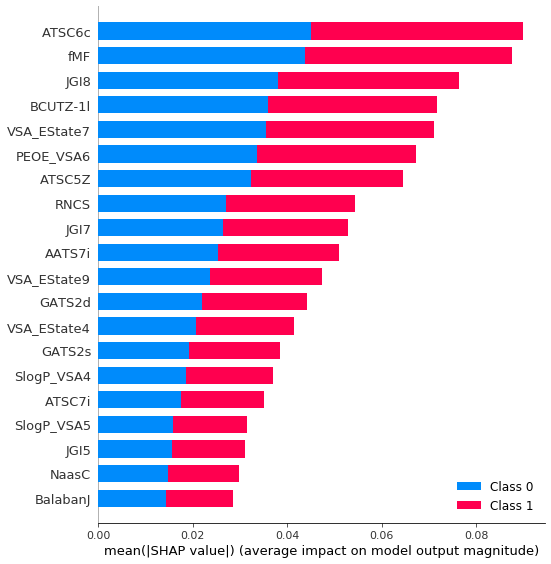

In [818]:
shap_values = shap.TreeExplainer(model).shap_values(train)
shap.summary_plot(shap_values, train, plot_type="bar")

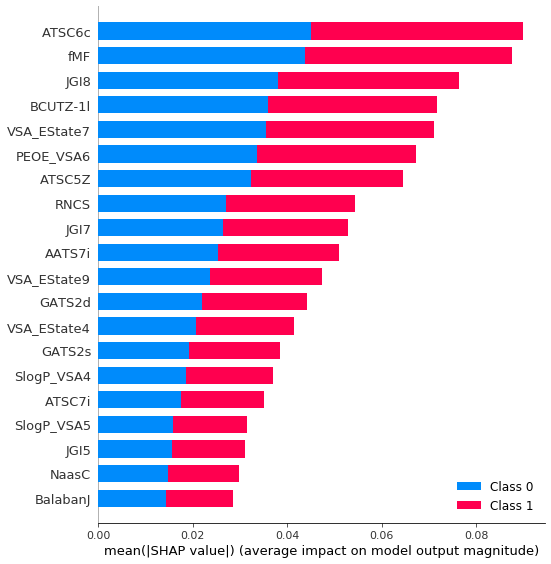

In [819]:
shap.summary_plot(shap_values, train)

In [820]:
shap.initjs()

In [821]:
X_output = test.copy()
X_output.loc[:,'predict'] = np.round(model.predict(X_output),2)

# Randomly pick some observations
random_picks = np.arange(1,7,2) # Every 50 rows
S = X_output.iloc[random_picks]
S

,ABC,nAcid,nBase,SpMax_A,SpMAD_A,VE1_A,VR1_A,nAromAtom,nSpiro,nBridgehead,...,JGI4,JGI5,JGI6,JGI7,JGI8,JGI9,JGI10,TopoShapeIndex,TSRW10,predict
0,24.793826,0,0,2.499482,1.322700,4.440538,597.574331,18,0,0,...,0.026757,0.028958,0.017766,0.015289,0.008381,0.006972,0.006926,0.875000,81.186093,1
18,23.128092,0,0,2.485026,1.265543,4.589305,245.959491,12,0,0,...,0.036926,0.024543,0.020116,0.014527,0.015052,0.009667,0.009047,1.000000,84.463671,0
26,16.401355,0,0,2.351515,1.311378,3.989248,179.986399,12,0,0,...,0.040362,0.023865,0.009515,0.014640,0.009574,0.007217,0.007414,0.857143,72.950827,0


In [784]:
def shap_plot(j):
    explainerModel = shap.TreeExplainer(model)
    shap_values_Model = explainerModel.shap_values(S)
    p = shap.force_plot(explainerModel.expected_value, shap_values_Model[j], S.iloc[[j]])
    return(p)

In [785]:
shap_plot(0)

Exception: In v0.20 force_plot now requires the base value as the first parameter! Try shap.force_plot(explainer.expected_value, shap_values) or for multi-output models try shap.force_plot(explainer.expected_value[0], shap_values[0]).

In [776]:
shap_plot(1)

In [777]:
shap_plot(2)

#### Pearson correlation

In [125]:
def cor_selector(X, y, num_feats):
    cor_list = []
    feature_name = X.columns.tolist()

    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)

    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-num_feats:]].columns.tolist()
    cor_support = [True if i in cor_feature else False for i in feature_name]
    
    return cor_support, cor_feature 

In [126]:
cor_support, cor_feature = cor_selector(train, ic50_train_enc, len(train.columns))
print(str(len(cor_feature)), 'selected features')

400 selected features


#### LASSO

In [127]:
embeded_lr_selector = SelectFromModel(LogisticRegression(penalty="l1"), max_features=len(train.columns))
embeded_lr_selector.fit(train_mmsc, ic50_train_enc)

embeded_lr_support = embeded_lr_selector.get_support()
embeded_lr_feature = train.loc[:,embeded_lr_support].columns.tolist()
print(str(len(embeded_lr_feature)), 'selected features')

6 selected features


In [128]:
train.drop(train.columns[np.where(embeded_lr_support == False)[0]], axis=1, inplace=True)
test.drop(test.columns[np.where(embeded_lr_support == False)[0]], axis=1, inplace=True)

#### Chi-squared

In [651]:
chi_selector = SelectKBest(chi2, k=400)
chi_selector.fit(train_mmsc, ic50_train_enc)

SelectKBest(k=400, score_func=<function chi2 at 0x7f26854ee378>)

In [652]:
chi_support = chi_selector.get_support()
chi_feature = train.loc[:,chi_support].columns.tolist()

In [653]:
print(str(len(chi_feature)), 'selected features')

400 selected features


#### Light Gradient Boosting Classifier

In [644]:
lgbc=LGBMClassifier(n_estimators=500, learning_rate=0.05, num_leaves=32, colsample_bytree=0.2,
            reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40)

In [645]:
embeded_lgb_selector = SelectFromModel(lgbc, max_features=len(train.columns))
embeded_lgb_selector.fit(train_mmsc, ic50_train_enc)

SelectFromModel(estimator=LGBMClassifier(boosting_type='gbdt',
                                         class_weight=None,
                                         colsample_bytree=0.2,
                                         importance_type='split',
                                         learning_rate=0.75, max_depth=-1,
                                         min_child_samples=20,
                                         min_child_weight=40,
                                         min_split_gain=0.01, n_estimators=500,
                                         n_jobs=-1, num_leaves=32,
                                         objective=None, random_state=None,
                                         reg_alpha=3, reg_lambda=1, silent=True,
                                         subsample=1.0,
                                         subsample_for_bin=200000,
                                         subsample_freq=0),
                max_features=400, norm_order=1, prefit=False,

In [646]:
embeded_lgb_support = embeded_lgb_selector.get_support()
embeded_lgb_feature = train.loc[:,embeded_lgb_support].columns.tolist()

In [647]:
print(str(len(embeded_lgb_feature)), 'selected features')

400 selected features


### Recursive feature elimination (RFE)

#### By Support Vector Classifier (SVC)

- Error report:

        * n_splits=2 cannot be greater than the number of members in each class.
        * The classifier does not expose "coef_" or "feature_importances_" attributes
        
Dependence on train/test split

In [554]:
svc = LinearSVC()
rfe = RFE(svc)
rfe.fit(train, ic50_train_enc)
print('Optimal number of features: {} - '.format(rfe.n_features_))
rfe.fit(train_sc, ic50_train_enc)
print('Optimal number of features: {} - Standard'.format(rfe.n_features_))
rfe.fit(train_mmsc, ic50_train_enc)
print('Optimal number of features: {} - MinMax'.format(rfe.n_features_))
rfe.fit(train_masc, ic50_train_enc)
print('Optimal number of features: {} - MaxAbs'.format(rfe.n_features_))
rfe.fit(train_rsc, ic50_train_enc)
print('Optimal number of features: {} - Robust'.format(rfe.n_features_))
rfe.fit(train_yjsc, ic50_train_enc)
print('Optimal number of features: {} - Yeo-Johnson'.format(rfe.n_features_))
rfe.fit(train_gsc, ic50_train_enc)
print('Optimal number of features: {} - Gaussian'.format(rfe.n_features_))
rfe.fit(train_usc, ic50_train_enc)
print('Optimal number of features: {} - uniform'.format(rfe.n_features_))
rfe.fit(train_nsc, ic50_train_enc)
print('Optimal number of features: {} - normalized'.format(rfe.n_features_))


Optimal number of features: 200 - 
Optimal number of features: 200 - Standard
Optimal number of features: 200 - MinMax
Optimal number of features: 200 - MaxAbs
Optimal number of features: 200 - Robust
Optimal number of features: 200 - Yeo-Johnson
Optimal number of features: 200 - Gaussian
Optimal number of features: 200 - uniform
Optimal number of features: 200 - normalized


In [555]:
#print(np.where(rfe.support_ == False)[0])

train.drop(train.columns[np.where(rfe.support_ == False)[0]], axis=1, inplace=True)
test.drop(test.columns[np.where(rfe.support_ == False)[0]], axis=1, inplace=True)

##### Standard

In [129]:
scaler = StandardScaler()

In [130]:
train_sc = scaler.fit_transform(train)
test_sc = scaler.fit_transform(test)

##### MinMax

In [131]:
scaler = MinMaxScaler()

In [132]:
train_mmsc = scaler.fit_transform(train)
test_mmsc = scaler.fit_transform(test)

##### MaxAbs

In [133]:
scaler = MaxAbsScaler()

In [134]:
train_masc = scaler.fit_transform(train)
test_masc = scaler.fit_transform(test)

##### Robust 

In [135]:
scaler = RobustScaler()

In [136]:
train_rsc = scaler.fit_transform(train)
test_rsc = scaler.fit_transform(test)

##### Power Transformer - Yeo-Johnson

In [137]:
scaler = PowerTransformer(method='yeo-johnson')

In [138]:
train_yjsc = scaler.fit_transform(train)
test_yjsc = scaler.fit_transform(test)

##### Quantile transformer - Gaussian

In [139]:
scaler = QuantileTransformer(output_distribution='normal')

In [140]:
train_gsc = scaler.fit_transform(train)
test_gsc = scaler.fit_transform(test)

##### Quantile transformer - Uniform

In [141]:
scaler = QuantileTransformer(output_distribution='uniform')

In [142]:
train_usc = scaler.fit_transform(train)
test_usc = scaler.fit_transform(test)

##### Normalizer

In [143]:
scaler = Normalizer()

In [144]:
train_nsc = scaler.fit_transform(train)
test_nsc = scaler.fit_transform(test)

#### By Ensemble, Random Forest (RF) and Extremely Randomized Trees (Extra Trees Classifier)

##### Ensemble

In [145]:
stump = DecisionTreeClassifier(max_depth=1)
ensemble = BaggingClassifier(base_estimator = stump, n_estimators = 1000, bootstrap = False)

In [146]:
stump.fit(train, np.ravel(ic50_train_enc))
ensemble.fit(train, np.ravel(ic50_train_enc))

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None,
                                                        criterion='gini',
                                                        max_depth=1,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        presort=False,
                                                        random_state=None,
                                                        splitter='best'),
       

In [147]:
y_pred_stump = stump.predict(test)
y_pred_ensemble = ensemble.predict(test)

In [148]:
stump_accuracy = metrics.accuracy_score(ic50_test_enc, y_pred_stump)
ensemble_accuracy = metrics.accuracy_score(ic50_test_enc, y_pred_ensemble)

In [149]:
print(f"The accuracy of the stump is {stump_accuracy*100:.1f} %")
print(f"The accuracy of the ensemble is {ensemble_accuracy*100:.1f} %")

The accuracy of the stump is 71.4 %
The accuracy of the ensemble is 71.4 %


##### Random Forest

In [150]:
tree = DecisionTreeClassifier(max_depth = 1, splitter = "best", max_features = "sqrt")

random_forest = BaggingClassifier(base_estimator = tree, n_estimators = 1000,bootstrap = True)

In [151]:
tree.fit(train, np.ravel(ic50_train_enc))
random_forest.fit(train, np.ravel(ic50_train_enc))

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None,
                                                        criterion='gini',
                                                        max_depth=1,
                                                        max_features='sqrt',
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        presort=False,
                                                        random_state=None,
                                                        splitter='best'),
     

In [152]:
y_pred_tree = tree.predict(test)
y_pred_random_forest = random_forest.predict(test)

In [153]:
tree_accuracy = metrics.accuracy_score(ic50_test_enc, y_pred_tree)
random_forest_accuracy = metrics.accuracy_score(ic50_test_enc, y_pred_random_forest)

In [154]:
print(f"The accuracy of the tree is {tree_accuracy*100:.1f} %")
print(f"The accuracy of the Random Forest is {random_forest_accuracy*100:.1f} %")

The accuracy of the tree is 57.1 %
The accuracy of the Random Forest is 71.4 %


##### Extra Trees Classifier

In [155]:
rm_tree = DecisionTreeClassifier(max_depth = 1, splitter = "random", max_features = "sqrt")

extra_trees = BaggingClassifier(base_estimator = stump, n_estimators = 1000, bootstrap = False)

In [156]:
rm_tree.fit(train, np.ravel(ic50_train_enc))
extra_trees.fit(train, np.ravel(ic50_train_enc))

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None,
                                                        criterion='gini',
                                                        max_depth=1,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        presort=False,
                                                        random_state=None,
                                                        splitter='best'),
       

In [157]:
y_pred_rm_tree = rm_tree.predict(test)
y_pred_extra_trees = extra_trees.predict(test)

In [158]:
rm_tree_accuracy = metrics.accuracy_score(ic50_test_enc, y_pred_rm_tree)
extra_trees_accuracy = metrics.accuracy_score(ic50_test_enc, y_pred_extra_trees)

In [159]:
print(f"The accuracy of the tree is {rm_tree_accuracy*100:.1f} %")
print(f"The accuracy of the Extra Trees is {extra_trees_accuracy*100:.1f} %")

The accuracy of the tree is 42.9 %
The accuracy of the Extra Trees is 71.4 %


##### Proceeding to RFE-CV with Random Forest Classifier

After several runs ...

In [ ]:
rfc = RandomForestClassifier(random_state=101)

In [ ]:
rfecv = RFECV(estimator=rfc, step=1, cv=StratifiedKFold(2), scoring='accuracy')

In [ ]:
rfecv.fit(train, ic50_train_enc)

In [ ]:
print('Optimal number of features: {}'.format(rfecv.n_features_))

In [ ]:
plt.figure(figsize=(16, 9))
plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
plt.ylabel('% Correct Classification', fontsize=14, labelpad=20)
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, color='#303F9F', linewidth=3)

plt.show()

###### Dropping least important descriptors

In [ ]:
print(np.where(rfecv.support_ == False)[0])

train.drop(train.columns[np.where(rfecv.support_ == False)[0]], axis=1, inplace=True)
test.drop(test.columns[np.where(rfecv.support_ == False)[0]], axis=1, inplace=True)

##### Descriptors' relevance

In [ ]:
dset = pd.DataFrame()
dset['attr'] = train.columns
dset['importance'] = rfecv.estimator_.feature_importances_

dset = dset.sort_values(by='importance', ascending=False)


plt.figure(figsize=(16, 14))
plt.barh(y=dset['attr'], width=dset['importance'], color='#1976D2')
plt.title('RFECV - Feature Importances', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Importance', fontsize=14, labelpad=20)
plt.show()



In [ ]:
dset.head()

### Support Vector Machine (SVM) 

#### Grid search cross-validation and SVM classificator

In [160]:
C_range = np.arange(0.01, 100, step=5)
gamma_range = np.arange(0.1, 10, step=2)
kernels = ["linear","sigmoid","rbf","poly"]
parameters = dict(gamma=gamma_range, C=C_range, kernel=kernels)

svc = SVC()
clf = GridSearchCV(svc, param_grid = parameters)

In [161]:
clf.fit(train, ic50_train_enc)

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': array([1.000e-02, 5.010e+00, 1.001e+01, 1.501e+01, 2.001e+01, 2.501e+01,
       3.001e+01, 3.501e+01, 4.001e+01, 4.501e+01, 5.001e+01, 5.501e+01,
       6.001e+01, 6.501e+01, 7.001e+01, 7.501e+01, 8.001e+01, 8.501e+01,
       9.001e+01, 9.501e+01]),
                         'gamma': array([0.1, 2.1, 4.1, 6.1, 8.1]),
                         'kernel': ['linear', 'sigmoid', 'rbf', 'poly']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [162]:
ypred = clf.predict(test)

In [163]:
print("Accuracy: {}".format(metrics.accuracy_score(ic50_test_enc, ypred)))

Accuracy: 0.7142857142857143


In [164]:
clf.fit(train_sc, ic50_train_enc)
ypred = clf.predict(test_sc)
print("Accuracy: {} - standard".format(metrics.accuracy_score(ic50_test_enc, ypred)))
      
clf.fit(train_mmsc, ic50_train_enc)
ypred = clf.predict(test_mmsc)
print("Accuracy: {} - MinMax".format(metrics.accuracy_score(ic50_test_enc, ypred)))

clf.fit(train_masc, ic50_train_enc)
ypred = clf.predict(test_masc)
print("Accuracy: {} - MaxAbs".format(metrics.accuracy_score(ic50_test_enc, ypred)))

clf.fit(train_rsc, ic50_train_enc)
ypred = clf.predict(test_rsc)
print("Accuracy: {} - Robust".format(metrics.accuracy_score(ic50_test_enc, ypred)))

clf.fit(train_gsc, ic50_train_enc)
ypred = clf.predict(test_gsc)
print("Accuracy: {} - Gaussian".format(metrics.accuracy_score(ic50_test_enc, ypred)))

clf.fit(train_usc, ic50_train_enc)
ypred = clf.predict(test_usc)
print("Accuracy: {} - Uniform".format(metrics.accuracy_score(ic50_test_enc, ypred)))

clf.fit(train_nsc, ic50_train_enc)
ypred = clf.predict(test_nsc)
print("Accuracy: {} - Normalized".format(metrics.accuracy_score(ic50_test_enc, ypred)))


The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.


Accuracy: 0.5714285714285714 - standard


The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.


Accuracy: 0.5714285714285714 - MinMax


The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.


Accuracy: 0.7142857142857143 - MaxAbs


The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.


Accuracy: 0.5714285714285714 - Robust


The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.


Accuracy: 0.42857142857142855 - Gaussian


The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.


Accuracy: 0.7142857142857143 - Uniform
Accuracy: 0.5714285714285714 - Normalized


The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.


#### Grid search cross-validation and SVM regressor

In [165]:
from sklearn.svm import SVR
C_range = np.arange(0.01, 100, step=5)
gamma_range = np.arange(0.1, 10, step=2)
kernels = ["linear","sigmoid","rbf","poly"]
parameters = dict(gamma=gamma_range, C=C_range, kernel=kernels)

svr = SVR()
clf = GridSearchCV(svr, param_grid = parameters)

In [166]:
clf.fit(train, ic50_train)

KeyboardInterrupt: 

In [693]:
ypred=clf.predict(test)

In [694]:
metrics.r2_score(ic50_test, ypred)

-0.005227693179183701

In [695]:
clf.fit(train_sc, ic50_train)
ypred = clf.predict(test_sc)
print("R²: {} - standard".format(metrics.r2_score(ic50_test, ypred)))
      
clf.fit(train_mmsc, ic50_train)
ypred = clf.predict(test_mmsc)
print("R²: {} - MinMax".format(metrics.r2_score(ic50_test, ypred)))

clf.fit(train_masc, ic50_train)
ypred = clf.predict(test_masc)
print("R²: {} - MaxAbs".format(metrics.r2_score(ic50_test, ypred)))

clf.fit(train_rsc, ic50_train)
ypred = clf.predict(test_rsc)
print("R²: {} - Robust".format(metrics.r2_score(ic50_test, ypred)))

clf.fit(train_gsc, ic50_train)
ypred = clf.predict(test_gsc)
print("R²: {} - Gaussian".format(metrics.r2_score(ic50_test, ypred)))

clf.fit(train_usc, ic50_train)
ypred = clf.predict(test_usc)
print("R²: {} - Uniform".format(metrics.r2_score(ic50_test, ypred)))

clf.fit(train_nsc, ic50_train)
ypred = clf.predict(test_nsc)
print("R²: {} - Normalized".format(metrics.r2_score(ic50_test, ypred)))

R²: 0.18433055913993546 - standard
R²: 0.4104811525576638 - MinMax
R²: 0.41386563391783093 - MaxAbs
R²: 0.47172261620472633 - Robust
R²: 0.4234135657434729 - Gaussian
R²: 0.5256240366362368 - Uniform
R²: 0.3435357804594451 - Normalized


### Neural networks

#### Multi-Layer Perceptor Classifier (MLPC)

In [167]:
mlp = MLPClassifier(hidden_layer_sizes=(13,13,13),max_iter=500)

In [168]:
mlp.fit(train,ic50_train_enc)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(13, 13, 13), learning_rate='constant',
              learning_rate_init=0.001, max_iter=500, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [169]:
predictions = mlp.predict(test)

In [170]:
print(confusion_matrix(ic50_test_enc,predictions))
print(classification_report(ic50_test_enc,predictions))

[[1 2]
 [0 4]]
              precision    recall  f1-score   support

           0       1.00      0.33      0.50         3
           1       0.67      1.00      0.80         4

    accuracy                           0.71         7
   macro avg       0.83      0.67      0.65         7
weighted avg       0.81      0.71      0.67         7



In [171]:
mlp.fit(train_sc,ic50_train_enc)
predictions = mlp.predict(test_sc)
print("Standard")
print(classification_report(ic50_test_enc,predictions))

mlp.fit(train_mmsc,ic50_train_enc)
predictions = mlp.predict(test_mmsc)
print("----------------------------------------------")
print("MinMax")
print(classification_report(ic50_test_enc,predictions))

mlp.fit(train_masc,ic50_train_enc)
predictions = mlp.predict(test_masc)
print("----------------------------------------------")
print("MaxAbs")
print(classification_report(ic50_test_enc,predictions))

mlp.fit(train_rsc,ic50_train_enc)
predictions = mlp.predict(test_rsc)
print("----------------------------------------------")
print("Robust")
print(classification_report(ic50_test_enc,predictions))

mlp.fit(train_gsc,ic50_train_enc)
predictions = mlp.predict(test_gsc)
print("----------------------------------------------")
print("Gaussian")
print(classification_report(ic50_test_enc,predictions))

mlp.fit(train_usc,ic50_train_enc)
predictions = mlp.predict(test_usc)
print("----------------------------------------------")
print("Uniform")
print(classification_report(ic50_test_enc,predictions))

mlp.fit(train_nsc,ic50_train_enc)
predictions = mlp.predict(test_nsc)
print("----------------------------------------------")
print("Normalized")
print(classification_report(ic50_test_enc,predictions))

Standard
              precision    recall  f1-score   support

           0       0.50      0.67      0.57         3
           1       0.67      0.50      0.57         4

    accuracy                           0.57         7
   macro avg       0.58      0.58      0.57         7
weighted avg       0.60      0.57      0.57         7

----------------------------------------------
MinMax
              precision    recall  f1-score   support

           0       0.50      0.33      0.40         3
           1       0.60      0.75      0.67         4

    accuracy                           0.57         7
   macro avg       0.55      0.54      0.53         7
weighted avg       0.56      0.57      0.55         7

----------------------------------------------
MaxAbs
              precision    recall  f1-score   support

           0       0.50      0.33      0.40         3
           1       0.60      0.75      0.67         4

    accuracy                           0.57         7
   macro av

### Gradient Boosting Classifier

#### Learning rates

A learning rate that maximizes accuracy in both training and test sets.

In [172]:
lr_list = [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]

for learning_rate in lr_list:
    gb_clf = GradientBoostingClassifier(n_estimators=20, learning_rate=learning_rate, max_features=2, max_depth=2, random_state=0)
    gb_clf.fit(train_sc, ic50_train_enc)

    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb_clf.score(train_sc, ic50_train_enc)))
    print("Accuracy score (test): {0:.3f}".format(gb_clf.score(test_sc, ic50_test_enc)))
    print()

Learning rate:  0.05
Accuracy score (training): 1.000
Accuracy score (test): 0.714

Learning rate:  0.075
Accuracy score (training): 1.000
Accuracy score (test): 0.571

Learning rate:  0.1
Accuracy score (training): 1.000
Accuracy score (test): 0.571

Learning rate:  0.25
Accuracy score (training): 1.000
Accuracy score (test): 0.571

Learning rate:  0.5
Accuracy score (training): 1.000
Accuracy score (test): 0.714

Learning rate:  0.75
Accuracy score (training): 1.000
Accuracy score (test): 0.571

Learning rate:  1
Accuracy score (training): 1.000
Accuracy score (test): 0.714



In [173]:
gb_clf2 = GradientBoostingClassifier(n_estimators=20, learning_rate=0.5, max_features=2, max_depth=2, random_state=0)
gb_clf2.fit(train_mmsc, ic50_train_enc)
predictions = gb_clf2.predict(test_mmsc)

print("Confusion Matrix:")
print(confusion_matrix(ic50_test_enc, predictions))

print("Classification Report")
print(classification_report(ic50_test_enc, predictions))

Confusion Matrix:
[[1 2]
 [1 3]]
Classification Report
              precision    recall  f1-score   support

           0       0.50      0.33      0.40         3
           1       0.60      0.75      0.67         4

    accuracy                           0.57         7
   macro avg       0.55      0.54      0.53         7
weighted avg       0.56      0.57      0.55         7



#### XGBoost Classifier

In [78]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from xgboost import XGBClassifier

In [79]:
xgb_clf = XGBClassifier()

In [ ]:
xgb_clf.fit(train_mmsc, ic50_train_enc)
xgb_clf

In [ ]:
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

In [ ]:
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))